In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from astropy.io import fits
from astropy.table import Table

from dotenv import load_dotenv
load_dotenv(override=True)

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)
from src.utils.constants import *
from src.utils.functions import *
from src.utils.CosmoFunc import *

df_combined = pd.DataFrame()
for survey in ["6dFGS", "SDSS", "LAMOST"]:
    df_temp = pd.read_csv(f"../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv")
    df_combined = pd.concat([df_combined, df_temp], axis=0).reset_index(drop=True)

# Trend with Redshift

Text(0, 0.5, '$\\eta$')

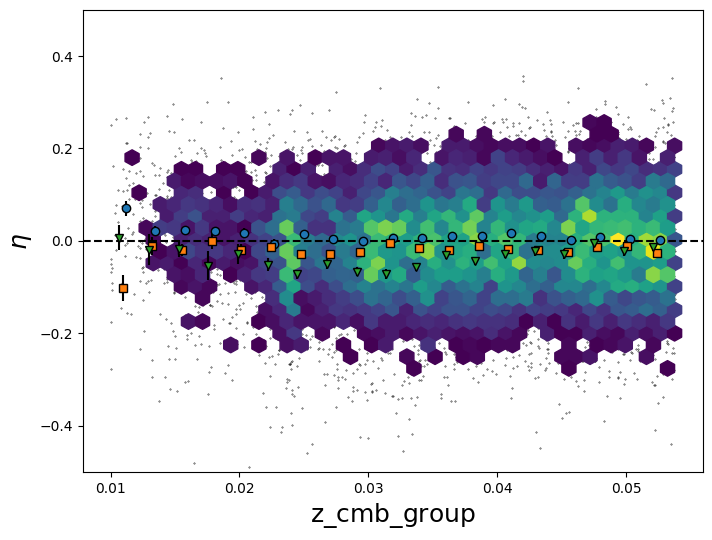

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df_combined['z_dist_est'], df_combined['logdist_all_combined'], s=0.1, c='k')
h = ax.hexbin(df_combined['z_dist_est'], df_combined['logdist_all_combined'], gridsize=(40, 20), mincnt=5, cmap="viridis")

# Redshift bins

z_bins = np.linspace(df_combined["z_dist_est"].min(), df_combined["z_dist_est"].max(), 20)
z_bins_labels = range(1, len(z_bins))
survey_colors = ["C0", "C1", "C2"]
survey_shapes = ["o", "s", "v"]

# Bin combined data on redshift (create shaded area)
df_combined_temp = df_combined.copy()
df_combined_temp['z_bin'] = pd.cut(df_combined_temp['z_dist_est'], z_bins, labels=z_bins_labels)
z_bins_middle = 0.5 * (z_bins[1:] + z_bins[:-1])
logdist_binned_mean = df_combined_temp[['z_bin', f'logdist_all_combined']].groupby(by='z_bin', observed=False).mean().values.ravel()
logdist_binned_std = df_combined_temp[['z_bin', f'logdist_all_combined']].groupby(by='z_bin', observed=False).std().to_numpy().ravel()
logdist_lower = df_combined_temp[['z_bin', f'logdist_all_combined']].groupby(by='z_bin', observed=False).quantile(0.16).to_numpy().ravel()
logdist_upper = df_combined_temp[['z_bin', f'logdist_all_combined']].groupby(by='z_bin', observed=False).quantile(0.84).to_numpy().ravel()
# ax.fill_between(z_bins_middle, y1=logdist_lower, y2=logdist_upper, color='r', alpha=0.6)
# ax.plot(z_bins_middle, logdist_binned_mean, c='r', alpha=0.8)

# Bin individual survey logdists
for i, survey in enumerate(["6dFGS", "SDSS", "LAMOST"]):
    x_offset = 0.00025 * i
    df = pd.read_csv(f"../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv")

    # Bin logdist on redshift
    df['z_bin'] = pd.cut(df['z_dist_est'], z_bins, labels=z_bins_labels)
    z_bins_middle = 0.5 * (z_bins[1:] + z_bins[:-1])
    logdist_binned_mean = df[['z_bin', f'logdist_all_combined']].groupby(by='z_bin', observed=False).mean().values.ravel()
    logdist_binned_std = df[['z_bin', f'logdist_all_combined']].groupby(by='z_bin', observed=False).std().to_numpy().ravel()
    logdist_binned_stderr = df[['z_bin', f'logdist_all_combined']].groupby(by='z_bin', observed=False).std().to_numpy().ravel() / np.sqrt(df[['z_bin', f'logdist_all_combined']].groupby(by='z_bin', observed=False).count().to_numpy().ravel())
    ax.errorbar(z_bins_middle - x_offset, logdist_binned_mean, yerr=logdist_binned_stderr, fmt=survey_shapes[i], mec='k', mfc=survey_colors[i], ecolor='k', alpha=1.0)

ax.axhline(y=0, c='k', ls="--")
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel("$\mathrm{z\_cmb\_group}$", fontsize=18)
ax.set_ylabel("$\eta$", fontsize=18)

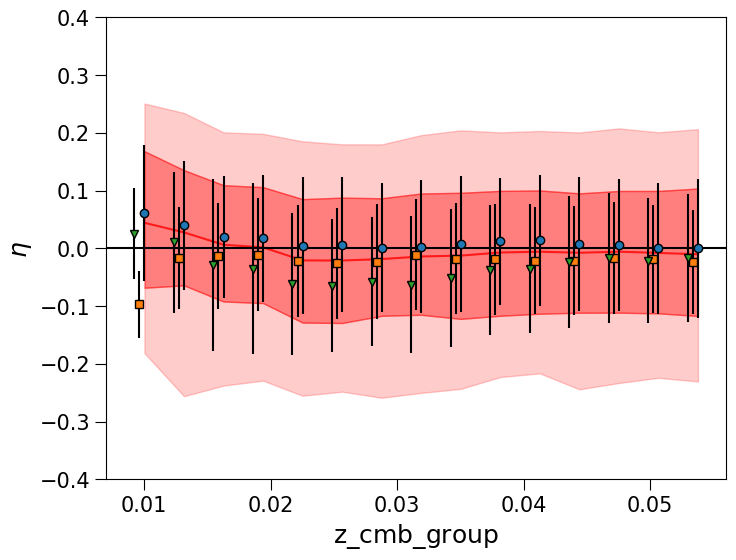

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.scatter(df_combined['z_dist_est'], df_combined['logdist_all_combined'], s=0.1, c='k')
# h = ax.hexbin(df_combined['z_dist_est'], df_combined['logdist_all_combined'], gridsize=(40, 20), mincnt=5, cmap="viridis")

# Redshift bins
z_trial = np.linspace(df_combined["z_dist_est"].min(), df_combined["z_dist_est"].max(), 15)
window_size = 0.005
survey_colors = ["C0", "C1", "C2"]
survey_shapes = ["o", "s", "v"]

# Bin combined data on redshift (create shaded area)
df_combined_temp = df_combined.copy()

logdist_means = []
logdist_stds = []
logdist_stderrs = []
logdist_lower_1sigmas = []
logdist_upper_1sigmas = []
logdist_lower_95pcts = []
logdist_upper_95pcts = []
for i, z in enumerate(z_trial):
    df_ = df_combined.copy()
    z_lower = z - window_size / 2
    z_upper = z + window_size / 2
    df_ = df_[(df_["z_dist_est"] >= z_lower) & (df_["z_dist_est"] <= z_upper)]
    logdist_mean = df_["logdist_all_combined"].mean()
    logdist_std = df_["logdist_all_combined"].std()
    logdist_stderr = df_["logdist_all_combined"].std() / np.sqrt(len(df_))
    logdist_lower_1sigma = df_["logdist_all_combined"].quantile(0.16)
    logdist_upper_1sigma = df_["logdist_all_combined"].quantile(0.84)
    logdist_lower_95pct = df_["logdist_all_combined"].quantile(0.025)
    logdist_upper_95pct = df_["logdist_all_combined"].quantile(0.975)

    logdist_means.append(logdist_mean)
    logdist_stds.append(logdist_std)
    logdist_stderrs.append(logdist_stderr)
    logdist_lower_1sigmas.append(logdist_lower_1sigma)
    logdist_upper_1sigmas.append(logdist_upper_1sigma)
    logdist_lower_95pcts.append(logdist_lower_95pct)
    logdist_upper_95pcts.append(logdist_upper_95pct)


ax.plot(z_trial, logdist_means, c="r", alpha=0.8)
ax.fill_between(z_trial, y1=logdist_lower_1sigmas, y2=logdist_upper_1sigmas, color="r", alpha=0.5)
ax.fill_between(z_trial, y1=logdist_upper_1sigmas, y2=logdist_upper_95pcts, color="r", alpha=0.2)
ax.fill_between(z_trial, y1=logdist_lower_95pcts, y2=logdist_lower_1sigmas, color="r", alpha=0.2)

# Plot individual survey's rolling mean
for j, survey in enumerate(["6dFGS", "SDSS", "LAMOST"]):
    df = pd.read_csv(f"../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv")
    offset = j * 0.0004

    logdist_means = []
    logdist_stds = []
    logdist_stderrs = []
    logdist_lower_1sigmas = []
    logdist_upper_1sigmas = []
    logdist_lower_95pcts = []
    logdist_upper_95pcts = []
    for i, z in enumerate(z_trial):
        df_ = df.copy()
        z_lower = z - window_size / 2
        z_upper = z + window_size / 2
        df_ = df_[(df_["z_dist_est"] >= z_lower) & (df_["z_dist_est"] <= z_upper)]
        logdist_mean = df_["logdist_all_combined"].mean()
        logdist_std = df_["logdist_all_combined"].std()
        logdist_stderr = df_["logdist_all_combined"].std() / np.sqrt(len(df_))
        logdist_lower_1sigma = df_["logdist_all_combined"].quantile(0.16)
        logdist_upper_1sigma = df_["logdist_all_combined"].quantile(0.84)
        logdist_lower_95pct = df_["logdist_all_combined"].quantile(0.025)
        logdist_upper_95pct = df_["logdist_all_combined"].quantile(0.975)

        logdist_means.append(logdist_mean)
        logdist_stds.append(logdist_std)
        logdist_stderrs.append(logdist_stderr)
        logdist_lower_1sigmas.append(logdist_lower_1sigma)
        logdist_upper_1sigmas.append(logdist_upper_1sigma)
        logdist_lower_95pcts.append(logdist_lower_95pct)
        logdist_upper_95pcts.append(logdist_upper_95pct)

    ax.errorbar(z_trial - offset, logdist_means, yerr=logdist_stds, fmt=survey_shapes[j], mec='k', mfc=survey_colors[j], ecolor='k', alpha=1.0)

ax.axhline(y=0, c='k')
ax.set_ylim(-0.4, 0.4)
ax.set_xlabel("$\mathrm{z\_cmb\_group}$", fontsize=18)
ax.set_ylabel("$\eta$", fontsize=18)

ax.tick_params(axis='both', which='both', labelsize=15, direction="out")
ax.tick_params(axis='both', which='major', length=8)
ax.tick_params(axis='both', which='minor', length=4)

# Trend with Absolute Magnitude/Luminosity

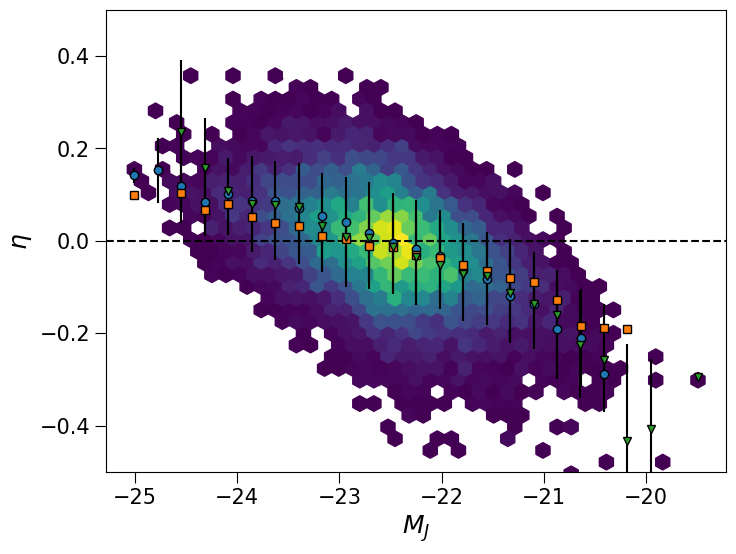

In [62]:
# Calculate J-band absolute magnitude
red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
d_C = sp.interpolate.splev(df_combined["z_dist_est"].to_numpy(), dist_spline)
d_L = (1 + df_combined["zhelio"]) * d_C * 10**6
df_combined["absMag_j"] = (df_combined["j_m_ext"] - df_combined["extinction_j"]) - 5 * (np.log10(d_L) - 1) - df_combined["kcor_j"]

# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(df_combined['absMag_j'], df_combined['logdist_all_combined'], s=0.1, c='k')
h = ax.hexbin(df_combined['absMag_j'], df_combined['logdist_all_combined'], gridsize=(40, 20), mincnt=1, cmap="viridis")

# Absolute magnitude bins
absmag_trial = np.linspace(df_combined["absMag_j"].min(), df_combined["absMag_j"].max(), 25)
window_size = 0.25
survey_colors = ["C0", "C1", "C2"]
survey_shapes = ["o", "s", "v"]

# Plot individual survey's rolling mean
for j, survey in enumerate(["6dFGS", "SDSS", "LAMOST"]):
    df = pd.read_csv(f"../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv")
    d_C = sp.interpolate.splev(df["z_dist_est"].to_numpy(), dist_spline)
    d_L = (1 + df["zhelio"]) * d_C * 10**6
    df["absMag_j"] = (df["j_m_ext"] - df["extinction_j"]) - 5 * (np.log10(d_L) - 1) - df["kcor_j"]
    offset = j * 0.0004

    logdist_means = []
    logdist_stds = []
    logdist_stderrs = []
    logdist_lower_1sigmas = []
    logdist_upper_1sigmas = []
    logdist_lower_95pcts = []
    logdist_upper_95pcts = []
    for i, absmag in enumerate(absmag_trial):
        df_ = df.copy()
        absmag_lower = absmag - window_size / 2
        absmag_upper = absmag + window_size / 2
        df_ = df_[(df_["absMag_j"] >= absmag_lower) & (df_["absMag_j"] <= absmag_upper)]
        logdist_mean = df_["logdist_all_combined"].mean()
        logdist_std = df_["logdist_all_combined"].std()
        logdist_stderr = df_["logdist_all_combined"].std() / np.sqrt(len(df_))
        logdist_lower_1sigma = df_["logdist_all_combined"].quantile(0.16)
        logdist_upper_1sigma = df_["logdist_all_combined"].quantile(0.84)
        logdist_lower_95pct = df_["logdist_all_combined"].quantile(0.025)
        logdist_upper_95pct = df_["logdist_all_combined"].quantile(0.975)

        logdist_means.append(logdist_mean)
        logdist_stds.append(logdist_std)
        logdist_stderrs.append(logdist_stderr)
        logdist_lower_1sigmas.append(logdist_lower_1sigma)
        logdist_upper_1sigmas.append(logdist_upper_1sigma)
        logdist_lower_95pcts.append(logdist_lower_95pct)
        logdist_upper_95pcts.append(logdist_upper_95pct)

    ax.errorbar(absmag_trial - offset, logdist_means, yerr=logdist_stds, fmt=survey_shapes[j], mec='k', mfc=survey_colors[j], ecolor='k', alpha=1.0)

ax.axhline(y=0, c='k', ls="--")
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel("$M_J$", fontsize=18)
ax.set_ylabel("$\eta$", fontsize=18)

ax.tick_params(axis='both', which='both', labelsize=15, direction="out")
ax.tick_params(axis='both', which='major', length=8)
ax.tick_params(axis='both', which='minor', length=4)

# Add mock contour

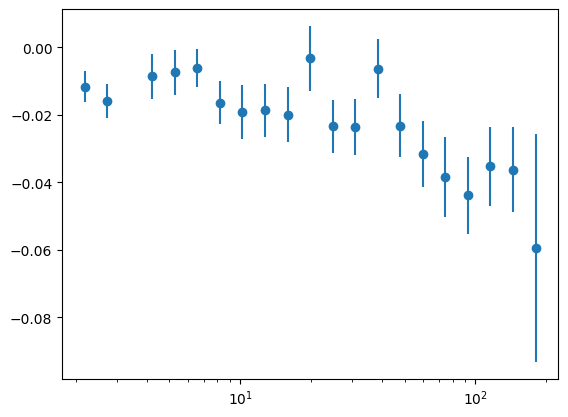

In [49]:
# Load data
df = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/sdss.csv")

# Richness bins
richness_bins = np.logspace(0, np.log10(200), 25)
richness_bins_labels = range(1, len(richness_bins))

df['richness_bin'] = pd.cut(df['Nr'], richness_bins, labels=richness_bins_labels)
richness_bins_middle = 0.5 * (richness_bins[1:] + richness_bins[:-1])
logdist_binned_mean = df[['richness_bin', f'logdist_all_combined']].groupby(by='richness_bin', observed=False).mean().values.ravel()
logdist_binned_std = df[['richness_bin', f'logdist_all_combined']].groupby(by='richness_bin', observed=False).std().to_numpy().ravel()
logdist_binned_stderr = df[['richness_bin', f'logdist_all_combined']].groupby(by='richness_bin', observed=False).std().to_numpy().ravel() / np.sqrt(df[['richness_bin', f'logdist_all_combined']].groupby(by='richness_bin', observed=False).count().to_numpy().ravel())
logdist_lower = df[['richness_bin', f'logdist_all_combined']].groupby(by='richness_bin', observed=False).quantile(0.16).to_numpy().ravel()
logdist_upper = df[['richness_bin', f'logdist_all_combined']].groupby(by='richness_bin', observed=False).quantile(0.84).to_numpy().ravel()

plt.errorbar(richness_bins_middle, logdist_binned_mean, yerr=logdist_binned_stderr, fmt='o')

# df_ = df[df["Nr"] >= 1]
# plt.scatter(df_["Nr"], df_["logdist_all_combined"], s=1)
plt.xscale("log")

## Try combining the logdists for every group first (group logdist = mean logdist)

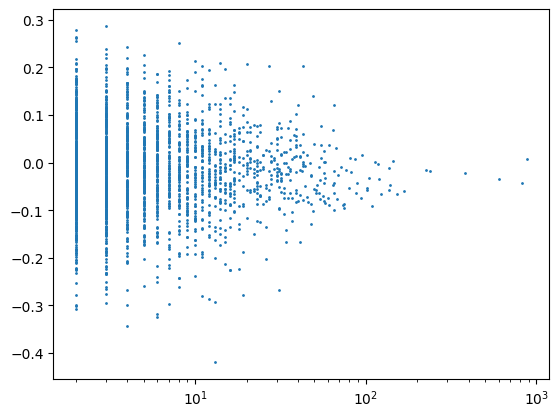

In [3]:
# Calculate mean logdist for every cluster
df = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/sdss.csv")
df_grouped = df[["Group", "logdist_all_combined"]].groupby(by="Group").mean().reset_index()

# req_cols = ['IDcl', 'Ngal', 'zcl']
with fits.open("../../data/external/tempel_group_sdss8/tempel_dr8gr.fits") as hdul:
    df_gr = Table(hdul[1].data).to_pandas().rename({'IDcl': 'Group', 'Ngal': 'Nr'}, axis=1)

df = df_grouped.merge(df_gr, on="Group", how="inner")

plt.scatter(df["Nr"], df["logdist_all_combined"], s=1)
plt.xscale("log")

## Combining group logdist with weighted mean

In [18]:
df = pd.read_csv("../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/sdss.csv")

group_list = df["Group"].unique()
logdist = []
logdist_err = []
for group in group_list:
    df_ = df.copy()
    df_ = df_[df_["Group"] == group]

    df_["weight"] = 1 / df_["logdist_err_all_combined"]**2
    df_["weight_x_logdist"] = df_["logdist_all_combined"] * df_["weight"]

    logdist_est = df_["weight_x_logdist"].sum() / df_["weight"].sum()
    logdist_err_est = 1 / (df_["weight"]**2).sum()
    
    logdist.append(logdist_est)
    logdist_err.append(logdist_err_est)

df_grouped = pd.DataFrame({
    "Group": group_list,
    "logdist": logdist,
    "logdist_err": logdist_err
})

# req_cols = ['IDcl', 'Ngal', 'zcl']
with fits.open("../../data/external/tempel_group_sdss8/tempel_dr8gr.fits") as hdul:
    df_gr = Table(hdul[1].data).to_pandas().rename({'IDcl': 'Group', 'Ngal': 'Nr'}, axis=1)

df = df_grouped.merge(df_gr, on="Group", how="inner")

<ErrorbarContainer object of 3 artists>

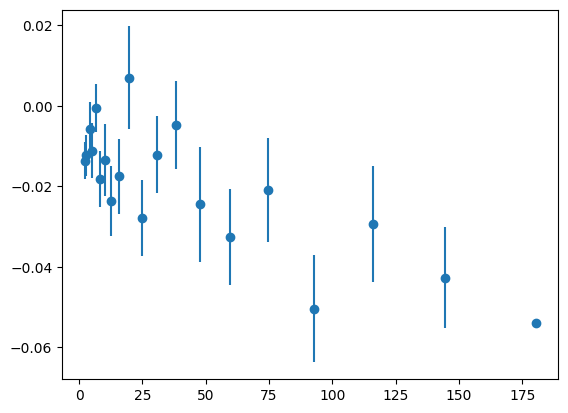

In [29]:
# Richness bins
richness_bins = np.logspace(0, np.log10(200), 25)
richness_bins_labels = range(1, len(richness_bins))

df['richness_bin'] = pd.cut(df['Nr'], richness_bins, labels=richness_bins_labels)
richness_bins_middle = 0.5 * (richness_bins[1:] + richness_bins[:-1])
logdist_binned_mean = df[['richness_bin', f'logdist']].groupby(by='richness_bin', observed=False).median().values.ravel()
logdist_binned_std = df[['richness_bin', f'logdist']].groupby(by='richness_bin', observed=False).std().to_numpy().ravel()
logdist_binned_stderr = df[['richness_bin', f'logdist']].groupby(by='richness_bin', observed=False).std().to_numpy().ravel() / np.sqrt(df[['richness_bin', f'logdist']].groupby(by='richness_bin', observed=False).count().to_numpy().ravel())
logdist_lower = df[['richness_bin', f'logdist']].groupby(by='richness_bin', observed=False).quantile(0.16).to_numpy().ravel()
logdist_upper = df[['richness_bin', f'logdist']].groupby(by='richness_bin', observed=False).quantile(0.84).to_numpy().ravel()

plt.errorbar(richness_bins_middle, logdist_binned_mean, yerr=logdist_binned_stderr, fmt='o')

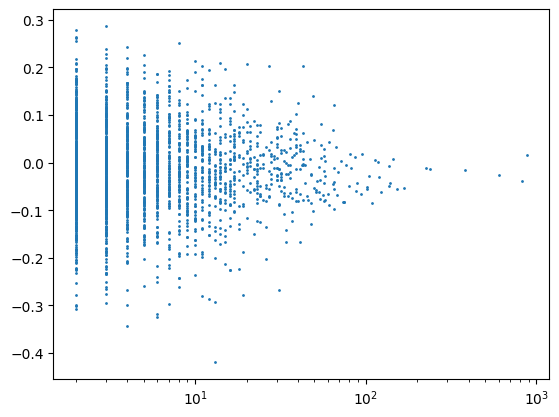

In [26]:
plt.scatter(df["Nr"], df["logdist"], s=1)
plt.xscale("log")

# Trend with Sersic Index

<ErrorbarContainer object of 3 artists>

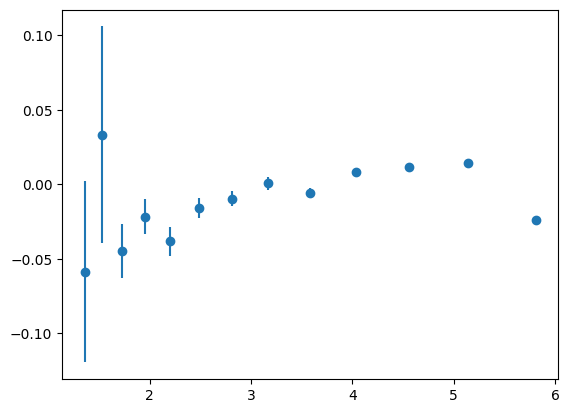

In [4]:
df_galfit = pd.read_csv("../../data/raw/r_e_jrl/combined/jhk_r_e.csv")[["tmass", "galfit_ser_j"]]
df = df_combined.merge(df_galfit, on="tmass")

# Sersic index bins
n_bins = np.logspace(0, np.log10(10), 20)
n_bins_labels = range(1, len(n_bins))

df['n_bin'] = pd.cut(df['galfit_ser_j'], n_bins, labels=n_bins_labels)
n_bins_middle = 0.5 * (n_bins[1:] + n_bins[:-1])
logdist_binned_mean = df[['n_bin', "logdist_all_combined"]].groupby(by='n_bin', observed=False).median().values.ravel()
logdist_binned_std = df[['n_bin', "logdist_all_combined"]].groupby(by='n_bin', observed=False).std().to_numpy().ravel()
logdist_binned_stderr = df[['n_bin', "logdist_all_combined"]].groupby(by='n_bin', observed=False).std().to_numpy().ravel() / np.sqrt(df[['n_bin', "logdist_all_combined"]].groupby(by='n_bin', observed=False).count().to_numpy().ravel())
logdist_lower = df[['n_bin', "logdist_all_combined"]].groupby(by='n_bin', observed=False).quantile(0.16).to_numpy().ravel()
logdist_upper = df[['n_bin', "logdist_all_combined"]].groupby(by='n_bin', observed=False).quantile(0.84).to_numpy().ravel()

plt.errorbar(n_bins_middle, logdist_binned_mean, yerr=logdist_binned_stderr, fmt='o')

# Trend vs redshift, absolute magnitude, sersic index

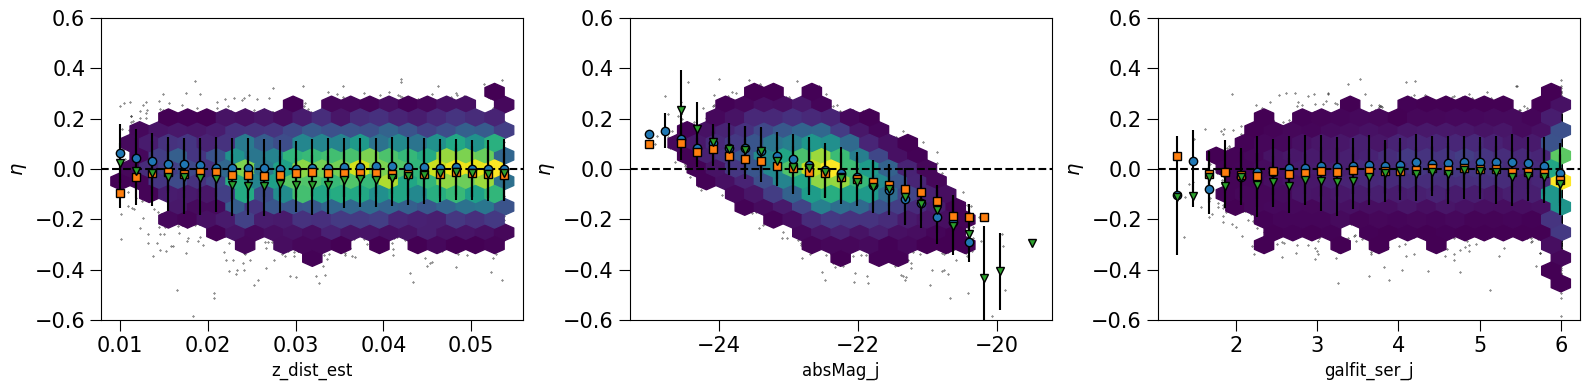

In [34]:
survey_list = ["6dFGS", "SDSS", "LAMOST"]
fig, axs = plt.subplots(ncols=3, figsize=(8 * 3 / 1.5, 6 / 1.5))

# Parameters for each plot
x_params = ["z_dist_est", "absMag_j", "galfit_ser_j"]
window_sizes = [0.005, 0.25, 0.25]
offsets = [0.0001, 0.0004, 0.005]
survey_colors = ["C0", "C1", "C2"]
survey_shapes = ["o", "s", "v"]

# Combine surveys
df_combined = pd.DataFrame()
for survey in survey_list:
    df_temp = pd.read_csv(f"../../data/foundation/logdist/smin_setting_1/fp_fit_method_0/{survey.lower()}.csv")
    df_temp["survey"] = survey
    df_combined = pd.concat([df_combined, df_temp], axis=0).reset_index(drop=True)

# Calculate J-band absolute magnitude
red_spline, lumred_spline, dist_spline, lumdist_spline, ez_spline = rz_table()
d_C = sp.interpolate.splev(df_combined["z_dist_est"].to_numpy(), dist_spline)
d_L = (1 + df_combined["zhelio"]) * d_C * 10**6
df_combined["absMag_j"] = (df_combined["j_m_ext"] - df_combined["extinction_j"]) - 5 * (np.log10(d_L) - 1) - df_combined["kcor_j"]

# Merge with John's GALFIT measurements to get sersic index
df_galfit = pd.read_csv("../../data/raw/r_e_jrl/combined/jhk_r_e.csv")[["tmass", "galfit_ser_j"]]
df_combined = df_combined.merge(df_galfit, on="tmass", how="left")

# Separate the dataframe again
dfs = []
for survey in survey_list:
    dfs.append(df_combined[df_combined["survey"] == survey])


for i, ax in enumerate(fig.axes):
    # Parameter to plot
    x_param = x_params[i]
    window_size = window_sizes[i]
    offset = i * offsets[i]

    ax.scatter(df_combined[x_param], df_combined['logdist_all_combined'], s=0.1, c='k')
    h = ax.hexbin(df_combined[x_param], df_combined['logdist_all_combined'], gridsize=(20, 10), mincnt=5, cmap="viridis")

    # Calculate rolling mean for each survey
    x_pts = np.linspace(df_combined[x_param].min(), df_combined[x_param].max(), 25)

    logdist_means_full = []
    logdist_stds_full = []
    logdist_stderrs_full = []
    for j, survey in enumerate(survey_list):
        df_ = dfs[j]
        x_trials = []
        logdist_means = []
        logdist_stds = []
        logdist_stderrs = []
        for x in x_pts:
            x_lower = x - window_size / 2
            x_upper = x + window_size / 2
            _ = df_[(df_[x_param] >= x_lower) & (df_[x_param] <= x_upper)]
            if not len(_):
                continue

            logdist_mean = _["logdist_all_combined"].mean()
            logdist_std = _["logdist_all_combined"].std()
            logdist_stderr = _["logdist_all_combined"].std() / np.sqrt(len(_))
            
            x_trials.append(x)
            logdist_means.append(logdist_mean)
            logdist_stds.append(logdist_std)
            logdist_stderrs.append(logdist_stderr)

        ax.errorbar(np.array(x_trials) - offset, logdist_means, yerr=logdist_stds, fmt=survey_shapes[j], mec='k', mfc=survey_colors[j], ecolor='k', alpha=1.0)
    
    ax.axhline(y=0, c='k', ls='--')

    ax.set_ylim(-0.6, 0.6)
    ax.set_xlabel(x_param, fontsize=12)
    ax.set_ylabel(r"$\eta$", fontsize=14)
    ax.tick_params(axis='both', which='both', labelsize=15, direction="out")
    ax.tick_params(axis='both', which='major', length=8)
    ax.tick_params(axis='both', which='minor', length=4)

fig.tight_layout()